# TODO

* Compute scores after dropping f < 0.5
* 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import pandas as pd
import scipy

In [2]:
import sklearn.metrics
import mir_eval

In [3]:
import cPickle as pickle

In [4]:
from glob import glob
import re

In [28]:
pd.set_option('precision', 4)
pd.set_option('max_rows', 2000)

In [6]:
np.set_printoptions(precision=3)
seaborn.set(style='darkgrid')

In [7]:
def plot_curve(file='', intervals=None, labels=None, scores=None, norm=None, min_score=0.0, **kwargs):
    
    file_name = file
    
    label_agreement = np.zeros((len(labels), len(labels)), dtype=bool)
    
    for i in range(len(labels)):
        for j in range(i, len(labels)):
            label_agreement[i, j] = (labels[i] == labels[j])
            label_agreement[j, i] = label_agreement[i, j]
    
    time_norm = 1
    
    durations = np.diff(intervals, axis=1).ravel()
    
    if norm == 'min':
        time_norm = np.minimum.outer(durations, durations)
        
    elif norm == 'max':
        time_norm = np.maximum.outer(durations, durations)
        
    elif norm == 'hmean':
        time_norm = 2./np.add.outer(durations, durations)
        time_norm *= np.multiply.outer(durations, durations)
    
    # TODO: have the label agreement index out nan-valued scores
    
    scores = scores / time_norm
    
    label_agreement[np.tril_indices_from(label_agreement, k=0)] = False
    
    label_agreement[~np.isfinite(scores)] = False
    
    label_disagreement = ~label_agreement
    
    label_disagreement[np.tril_indices_from(label_disagreement, k=0)] = False
    
    label_disagreement[~np.isfinite(scores)] = False
    
    tp_scores = scores[label_agreement]
    fp_scores = scores[label_disagreement]
    
    num_pos = np.sum(label_agreement)
    num_neg = np.sum(label_disagreement)
    
    y_true = np.concatenate([np.zeros(len(tp_scores)), np.ones(len(fp_scores))])
    y_score = np.concatenate([tp_scores, fp_scores])
    
    fpr, tpr, thr = sklearn.metrics.roc_curve(y_true, y_score)
    
    tp = num_pos * tpr
    fp = num_neg * fpr
    
    precision = tp / (tp + fp)
    recall = tpr
    
    fmeasure = np.asarray([mir_eval.util.f_measure(p, r) for p, r in zip(precision, recall)])
    
    k = np.argmax(fmeasure)
    thr_opt = thr[k]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.5)
    
    plt.plot(fpr, tpr)
    plt.plot(fpr[k], tpr[k], color='r', marker='*', markersize=10, alpha=0.5)
   
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(file_name)
    
    plt.subplot(1,3,2)
    plt.plot(recall, precision)
    plt.plot(recall[k], precision[k], marker='*', markersize=10, alpha=0.5, color='r')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('norm={}'.format(norm))
   
    plt.subplot(1,3,3)
    plt.plot(thr, fmeasure)
    k = np.argmax(fmeasure)
    plt.plot(thr[k], fmeasure[k], marker='*', markersize=10, alpha=0.5, color='r')
   
    plt.xlabel(r'$\theta$')
    plt.ylabel('$F_1$')
    plt.title(r'({:.3f}, {:.3f})'.format(thr[k], fmeasure[k]))
    plt.tight_layout()
    
    return thr[k], fmeasure[k]

In [15]:
def summarize_results(files):
    
    data = {}
    
    for fname in files:
        results = pickle.load(open(fname, 'r'))
        
        fscores = pd.DataFrame.from_dict([f['fmeasures'] for f in results['file_scores']
                                          if f['fmeasures'] is not None])
        
        match = re.match('.*scores_datasetE(?P<dataset>.*?)E(?P<scale>.*?)_distE(?P<metric>.*).pk', fname)

        fscores['dataset'] = pd.Series(match.group('dataset'), index=fscores.index)
        fscores['scale'] = pd.Series(match.group('dataset') + '_' + match.group('scale'), index=fscores.index)
        fscores['metric'] = pd.Series(match.group('metric'), index=fscores.index)
        
        data[fname] = fscores
        
    return data

In [16]:
output = summarize_results(sorted(glob('../data/*.pk')))

In [17]:
all_results = pd.concat(output.values())

In [31]:
all_results_ = all_results

In [32]:
all_results = all_results_[all_results_['none'] > 0.5]

scale                      metric     
Isophonics_level_function  L1             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           L2             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           correlation    [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
SALAMI_level_function      L1             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           L2             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           correlation    [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
SALAMI_level_large_scale   L1             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           L2             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           correlation    [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
SALAMI_level_small_scale   L1             [[Axes(0.125,0.125;0.158163x0.775), Axes(0.330...
                           L2            

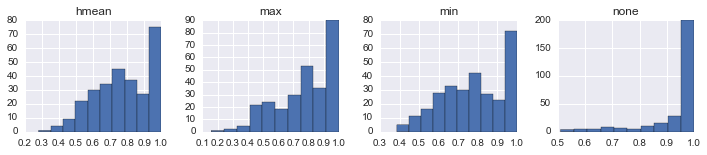

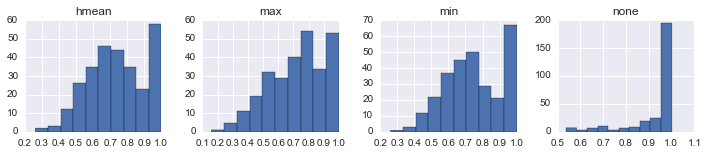

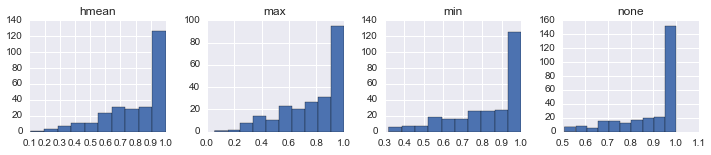

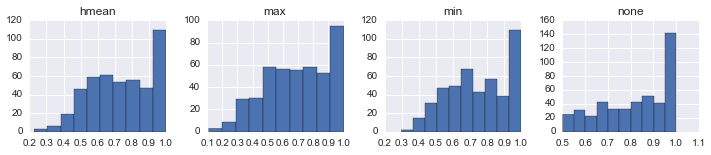

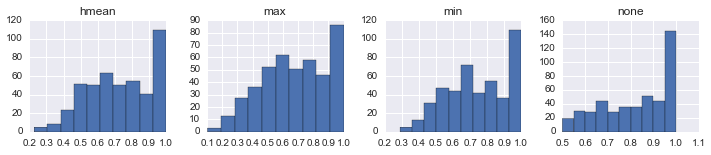

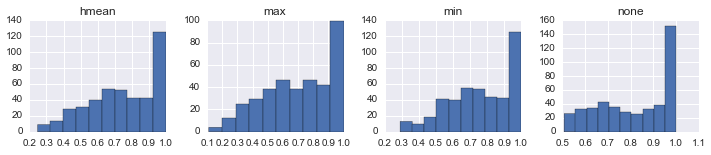

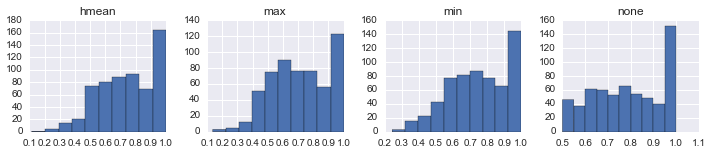

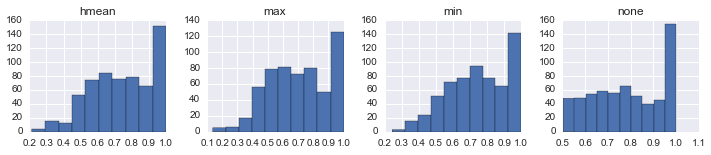

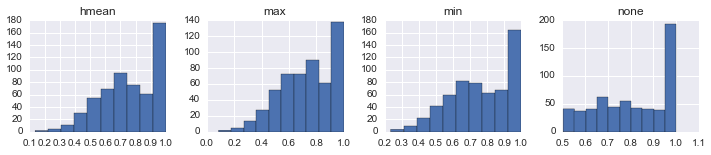

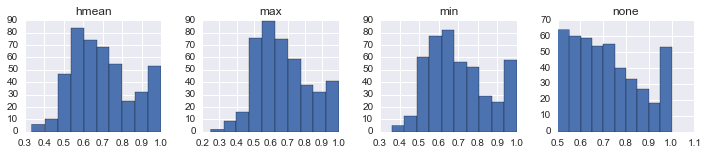

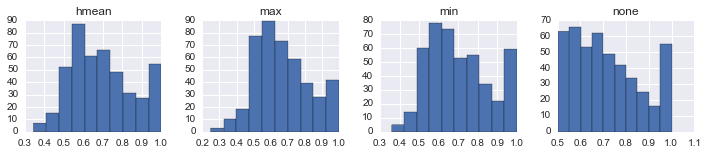

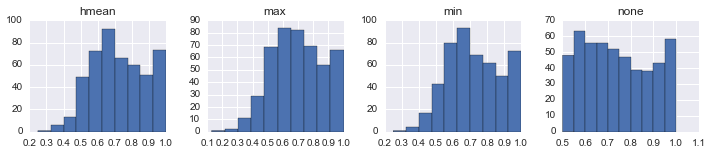

In [33]:
all_results.groupby(['scale', 'metric']).hist(layout=(1,4), figsize=(12,2))

In [34]:
print all_results.groupby(['scale', 'metric']).mean()

                                       hmean    max    min   none
scale                     metric                                 
Isophonics_level_function L1           0.778  0.783  0.779  0.936
                          L2           0.744  0.727  0.752  0.934
                          correlation  0.815  0.780  0.836  0.895
SALAMI_level_function     L1           0.741  0.694  0.751  0.824
                          L2           0.734  0.680  0.744  0.827
                          correlation  0.750  0.704  0.764  0.820
SALAMI_level_large_scale  L1           0.749  0.714  0.755  0.790
                          L2           0.748  0.707  0.752  0.788
                          correlation  0.764  0.735  0.769  0.813
SALAMI_level_small_scale  L1           0.696  0.674  0.702  0.717
                          L2           0.697  0.671  0.704  0.716
                          correlation  0.725  0.698  0.725  0.742


In [35]:
all_results.groupby(['scale', 'metric']).describe()

hmean      max      min  \
scale                     metric                                         
Isophonics_level_function L1          count  284.000  280.000  287.000   
                                      mean     0.778    0.783    0.779   
                                      std      0.166    0.189    0.163   
                                      min      0.281    0.158    0.386   
                                      25%      0.652    0.660    0.664   
                                      50%      0.780    0.813    0.776   
                                      75%      0.933    0.957    0.939   
                                      max      1.000    1.000    1.000   
                          L2          count  284.000  278.000  287.000   
                                      mean     0.744    0.727    0.752   
                                      std      0.168    0.189    0.168   
                                      min      0.262    0.158    0.262   
                                      25%      0.622    0.588    0.622   
                                      50%      0.738    0.754    0.748   
                                      75%      0.888    0.879    0.901   
                                      max      1.000    1.000    1.000   
                          correlation count  273.000  232.000  274.000   
                                      mean     0.815    0.780    0.836   
                                      std      0.202    0.224    0.182   
                                      min      0.108    0.056    0.320   
                                      25%      0.685    0.616    0.719   
                                      50%      0.889    0.854    0.896   
                                      75%      1.000    0.989    1.000   
                                      max      1.000    1.000    1.000   
SALAMI_level_function     L1          count  460.000  446.000  459.000   
                                      mean     0.741    0.694    0.751   
                                      std      0.187    0.214    0.179   
                                      min      0.228    0.112    0.298   
                                      25%      0.593    0.536    0.608   
                                      50%      0.740    0.700    0.750   
                                      75%      0.915    0.877    0.919   
                                      max      1.000    1.000    1.000   
                          L2          count  455.000  434.000  454.000   
                                      mean     0.734    0.680    0.744   
                                      std      0.193    0.217    0.184   
                                      min      0.228    0.103    0.290   
                                      25%      0.582    0.528    0.607   
                                      50%      0.731    0.683    0.746   
                                      75%      0.912    0.856    0.920   
                                      max      1.000    1.000    1.000   
                          correlation count  437.000  379.000  442.000   
                                      mean     0.750    0.704    0.764   
                                      std      0.201    0.230    0.190   
                                      min      0.248    0.112    0.290   
                                      25%      0.599    0.524    0.623   
                                      50%      0.757    0.725    0.770   
                                      75%      0.947    0.916    0.947   
                                      max      1.000    1.000    1.000   
SALAMI_level_large_scale  L1          count  610.000  567.000  616.000   
                                      mean     0.749    0.714    0.755   
                                      std      0.189    0.192    0.181   
                                      min      0.116    0.138    0.244   
                                      25%      0.60

---

In [14]:
vars().update(pickle.load(open('../data/scores_datasetESALAMI_levelEsmall_scale_distEcorrelation.pk', 'r')))

In [15]:
fscores = pd.DataFrame.from_dict([f['fmeasures'] for f in file_scores if f['fmeasures'] is not None])

In [16]:
fscores.describe()

,hmean,max,min,none
count,668.000,652.000,664.000,665.000
mean,0.640,0.619,0.636,0.650
std,0.212,0.212,0.211,0.211
min,0.109,0.096,0.109,0.114
25%,0.483,0.461,0.474,0.502
50%,0.645,0.614,0.640,0.652
75%,0.806,0.778,0.793,0.811
max,1.000,1.000,1.000,1.000


(0.31321433, 0.98245614035087714)
(0.019467199829822143, 0.6724202626641651)
(0.019174352437899125, 0.57854560064282845)
(0.032161135357831182, 0.63529411764705879)


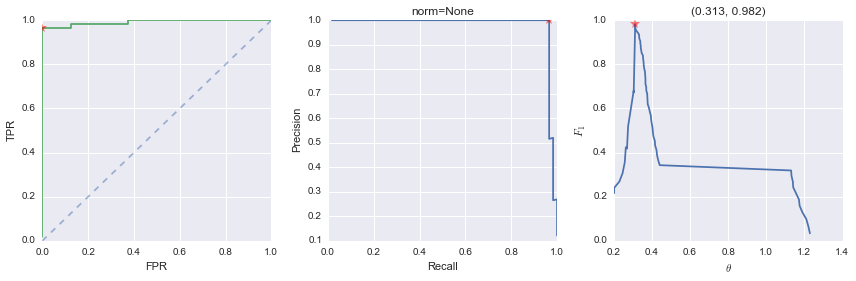

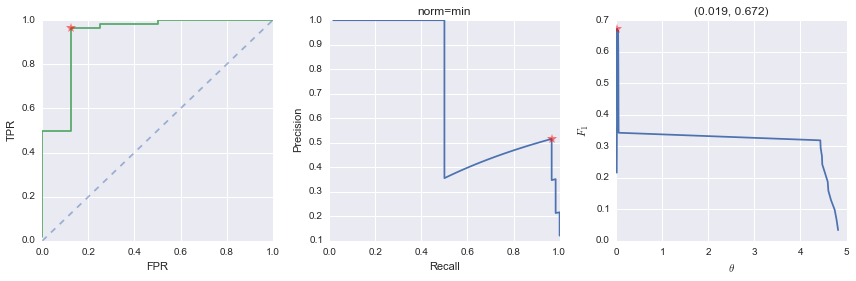

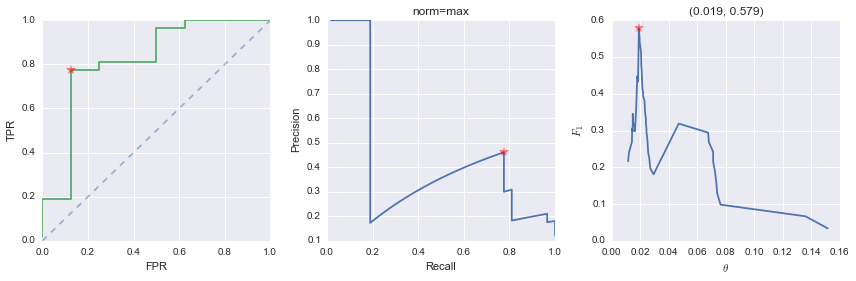

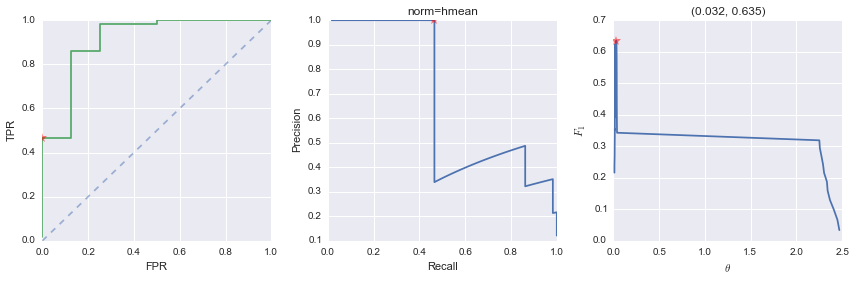

In [17]:
k = 382
for norm in [None, 'min', 'max', 'hmean']:
    print plot_curve(norm=norm, **file_scores[k])

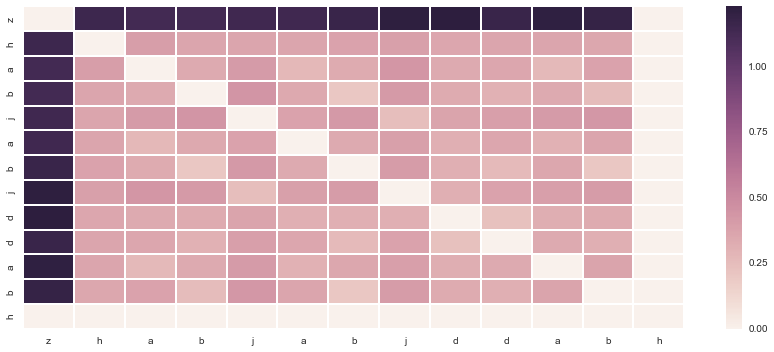

In [19]:
plt.figure(figsize=(12,5))
seaborn.heatmap(file_scores[k]['scores'],
                yticklabels=file_scores[k]['labels'],
                xticklabels=file_scores[k]['labels'])
plt.tight_layout()